In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [8]:
import pandas as pd
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Date range
date_range = pd.date_range(start='2019-01-01', end='2023-12-31', freq='M')

# Generate sample sales data
def generate_sales_data(base, seasonality, trend, noise_level=0.1):
    n = len(date_range)
    trend_component = trend * np.arange(n)
    seasonality_component = seasonality * np.sin(np.linspace(0, 2 * np.pi * 5, n))  # Seasonality over 5 years
    noise = noise_level * np.random.randn(n) * base
    sales = base + trend_component + seasonality_component + noise
    return sales

# Parameters
base_sales = 500  # Base sales value
trend = 5  # Trend component
seasonality = 100  # Seasonality component

# Generate data
sales_data = generate_sales_data(base_sales, seasonality, trend)

# Create DataFrame
sales_df = pd.DataFrame({'Date': date_range, 'Sales': sales_data})

# Ensure no negative sales
sales_df['Sales'] = sales_df['Sales'].apply(lambda x: max(x, 0))

print(sales_df.head())


        Date       Sales
0 2019-01-31  524.835708
1 2019-02-28  548.853365
2 2019-03-31  629.860735
3 2019-04-30  691.116054
4 2019-05-31  593.065774


In [9]:
sales_df.shape

(60, 2)

In [10]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    60 non-null     datetime64[ns]
 1   Sales   60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [11]:
sales_df['Sales'].sum()

38386.03595078853

In [13]:
sales_df = sales_df.rename(columns={'Date': 'ds',
                        'Sales': 'y'})

sales_df.head()

ds           y
0 2019-01-31  524.835708
1 2019-02-28  548.853365
2 2019-03-31  629.860735
3 2019-04-30  691.116054
4 2019-05-31  593.065774

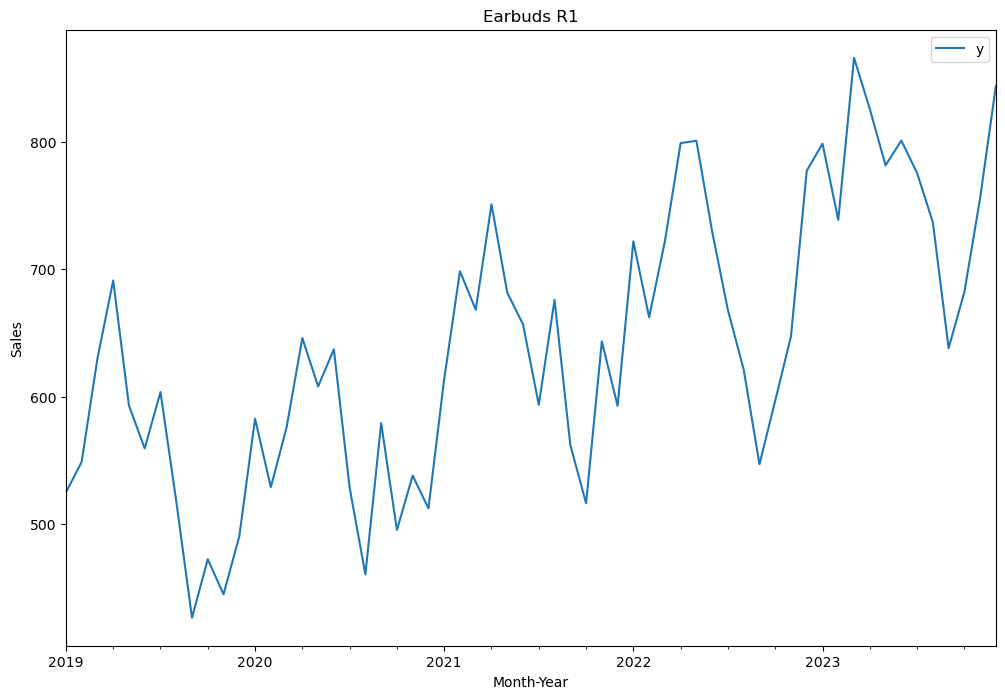

In [15]:
ax = sales_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Earbuds R1')
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [18]:
adf_test(sales_df['y'])

ADF Statistics: 0.8731600976183209
p- value: 0.9927298687740623
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [19]:
train= sales_df[:57]
test=sales_df[57:]

# Hyperparameter Tuning

In [20]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:03 - cmdstanpy - INFO - Chain [1] done processing
15:27:09 - cmdstanpy - INFO - Chain [1] start processing
15:27:09 - cmdstanpy - INFO - Chain [1] done processing
15:27:19 - cmdstanpy - INFO - Chain [1] start processing
15:27:19 - cmdstanpy - INFO - Chain [1] done processing
15:27:25 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing
15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing
15:27:35 - cmdstanpy - INFO - Chain [1] start processing
15:27:36 - cmdstanpy - INFO - Chain [1] done processing
15:27:41 - cmdstanpy - INFO - Chain [1] start processing
15:27:41 - cmdstanpy - INFO - Chain [1] done processing
15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:47 - cmdstanpy - INFO - Chain [1] done processing
15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:53 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

          rmse  
0    80.302960  
1    85.367870  
2    52.773416  
3    55.656488  
4    52.505128  
..         ...  
67  

In [21]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
26                    0.100                     0.10         additive   
14                    0.010                     0.10         additive   
8                     0.001                     5.00         additive   
27                    0.100                     0.10   multiplicative   
16                    0.010                     1.00         additive   
..                      ...                      ...              ...   
49                    0.300                     0.01   multiplicative   
68                    0.500                     5.00         additive   
60                    0.500                     0.01         additive   
61                    0.500                     0.01   multiplicative   
70                    0.500                    10.00         additive   

          rmse  
26   50.807017  
14   52.062493  
8    52.124250  
27   52.239606  
16   52.313915  
..         ...  
49   89.131895  
68   89.201190  
60   95.964877  
61  100.576573  
70  101.765190  

[72 rows x 4 columns]

In [22]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [23]:
# Create a Prophet model
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, seasonality_mode= 'additive',
                interval_width=0.95)

In [24]:
model.fit(train)

15:44:37 - cmdstanpy - INFO - Chain [1] start processing
15:44:38 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
len(test)

3

In [26]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [27]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [28]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [29]:
forecasted_df

ds        yhat  yhat_lower  yhat_upper
57 2023-10-01  695.217282  624.035241  763.773346
58 2023-11-01  665.808320  594.317259  735.237007
59 2023-12-01  728.860303  657.192323  793.471691

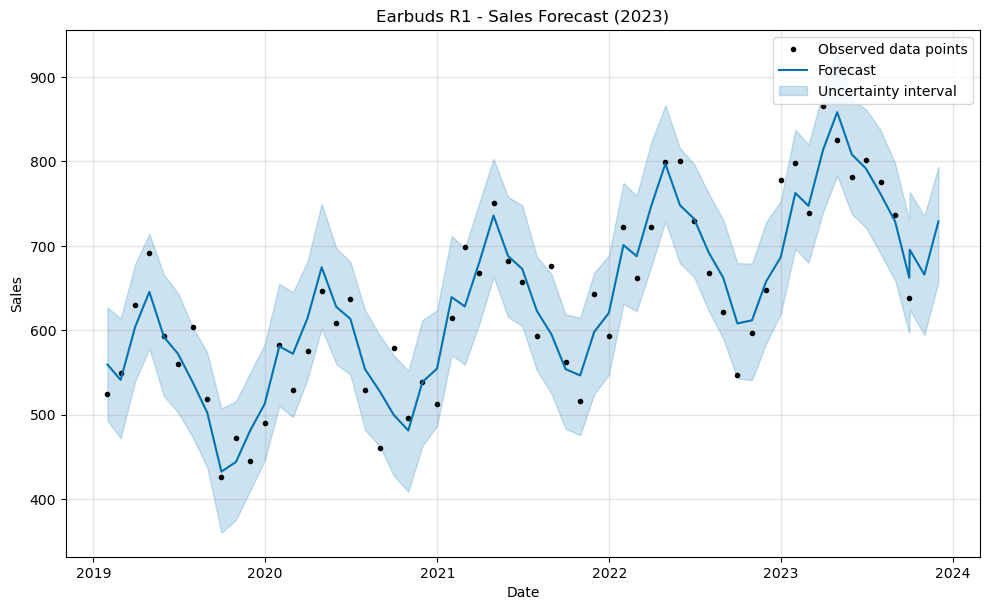

In [30]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Earbuds R1 - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

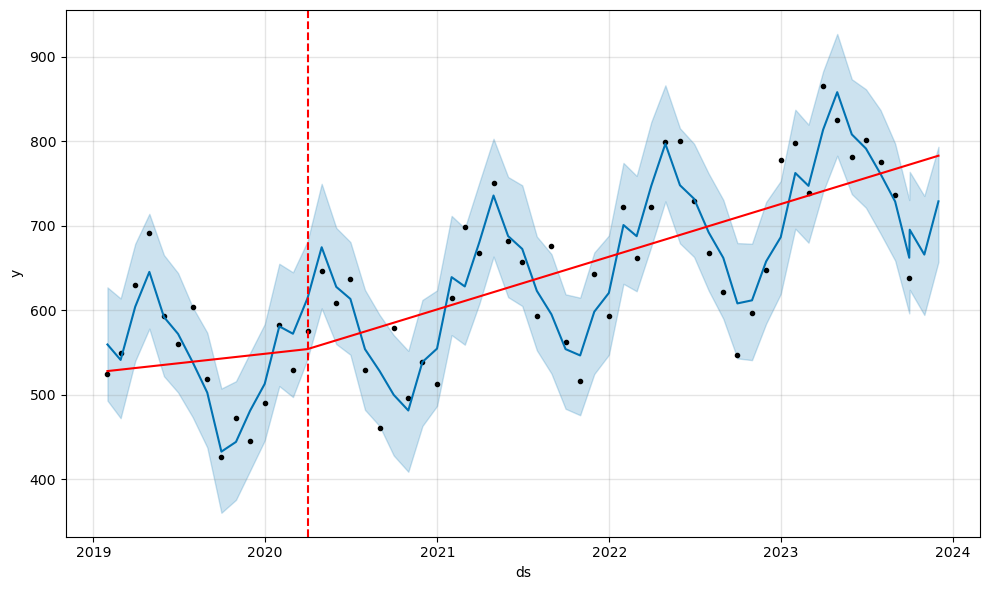

In [31]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

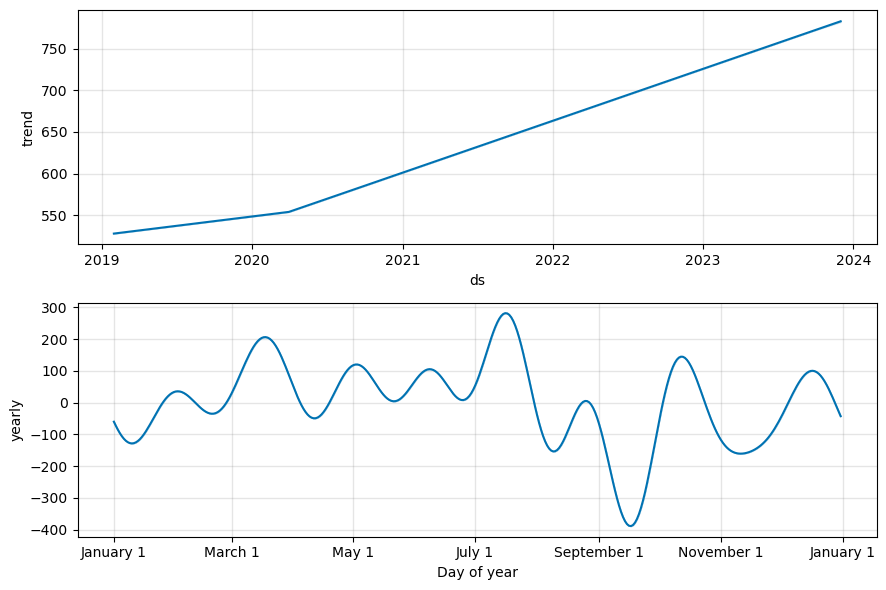

In [32]:
fig2 = model.plot_components(forecast)

In [33]:
forecasted_df

ds        yhat  yhat_lower  yhat_upper
57 2023-10-01  695.217282  624.035241  763.773346
58 2023-11-01  665.808320  594.317259  735.237007
59 2023-12-01  728.860303  657.192323  793.471691

In [36]:
sales_df.tail(3) 

ds           y
57 2023-10-31  682.063073
58 2023-11-30  755.796592
59 2023-12-31  843.777256

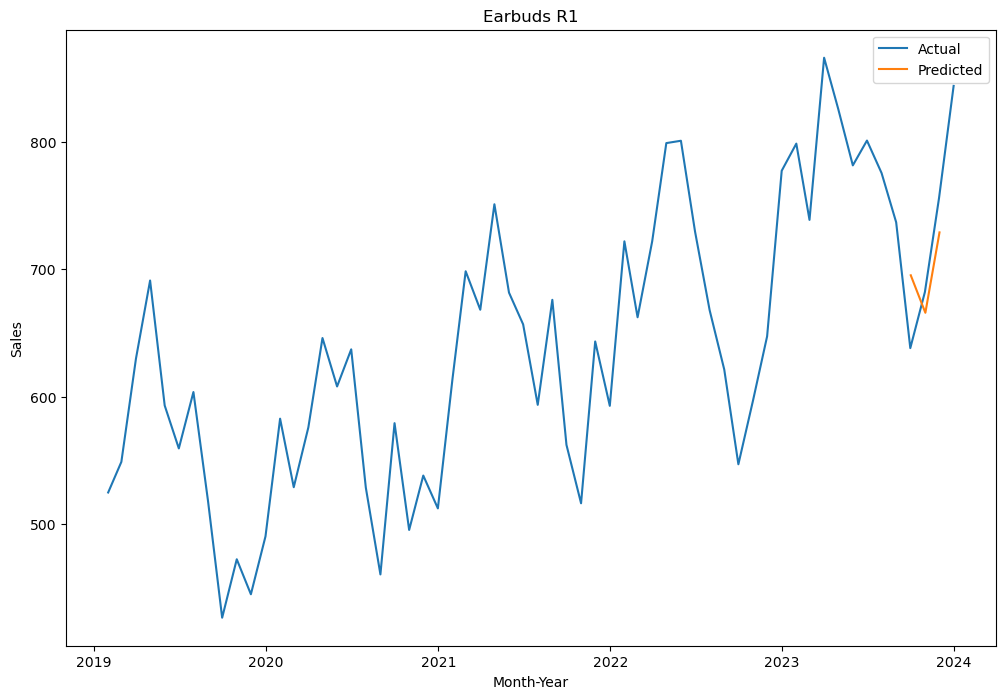

In [37]:
# Reset index of sales_b DataFrame
sales_d_reset_index = sales_df.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_d_reset_index['ds'], sales_d_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Earbuds R1')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [38]:
#model evaluation

In [39]:
pred=forecasted_df['yhat']
test_df=test['y']

In [40]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 72.686
MAPE - FB PROPHET: 0.092
MSE - FB PROPHET: 7158.943
RMSE - FB PROPHET: 84.611


In [41]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [42]:
from prophet.diagnostics import cross_validation
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [43]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

horizon           mse        rmse         mae      mape     mdape  \
0  21 days   2159.692867   46.472496   39.674226  0.071085  0.093053   
1  22 days   2191.444887   46.812871   41.575980  0.073319  0.093053   
2  23 days   1611.537265   40.143957   35.234683  0.059024  0.050167   
3  24 days    965.631750   31.074616   28.541469  0.040468  0.050167   
4  26 days    949.444829   30.813063   27.730896  0.040692  0.050167   
5  27 days   1341.642836   36.628443   32.286456  0.044107  0.057219   
6  28 days   1632.562836   40.404985   35.649288  0.045196  0.060410   
7  29 days   1719.559555   41.467572   38.853510  0.048201  0.060410   
8  48 days    940.050602   30.660245   26.301749  0.034042  0.023705   
9  50 days   3426.129759   58.533151   43.185218  0.062674  0.023705   
10 51 days   4947.960984   70.341744   66.187627  0.099771  0.087934   
11 53 days   2850.137726   53.386681   52.917857  0.075596  0.073857   
12 55 days   3313.646992   57.564286   57.177486  0.083686  0.087934   
13 56 days   1337.832500   36.576393   24.947745  0.039291  0.012729   
14 58 days    649.247393   25.480333   18.427714  0.024066  0.012729   
15 60 days    669.294545   25.870728   19.855638  0.025921  0.014132   
16 78 days   1147.977403   33.881815   30.655005  0.042619  0.055059   
17 80 days   1018.875648   31.919832   29.066762  0.046952  0.058665   
18 82 days    635.438948   25.207914   20.996425  0.034517  0.028581   
19 83 days    148.756519   12.196578    8.894756  0.012724  0.006911   
20 85 days   3581.691335   59.847233   38.962367  0.069317  0.028581   
21 87 days  11284.849481  106.230172  103.265605  0.148173  0.172576   
22 88 days   7784.272671   88.228525   70.502364  0.087446  0.084421   
23 90 days   4261.088754   65.277016   47.007989  0.061921  0.051924   

       smape  coverage  
0   0.067687  1.000000  
1   0.069897  1.000000  
2   0.057411  1.000000  
3   0.040336  1.000000  
4   0.040556  1.000000  
5   0.042950  1.000000  
6   0.045199  1.000000  
7   0.048334  1.000000  
8   0.034713  1.000000  
9   0.066569  0.666667  
10  0.104290  0.666667  
11  0.077206  1.000000  
12  0.083352  0.666667  
13  0.037651  0.666667  
14  0.023545  1.000000  
15  0.025447  1.000000  
16  0.041604  1.000000  
17  0.045681  1.000000  
18  0.033628  1.000000  
19  0.012581  1.000000  
20  0.063886  0.666667  
21  0.149488  0.000000  
22  0.094123  0.333333  
23  0.064824  0.666667

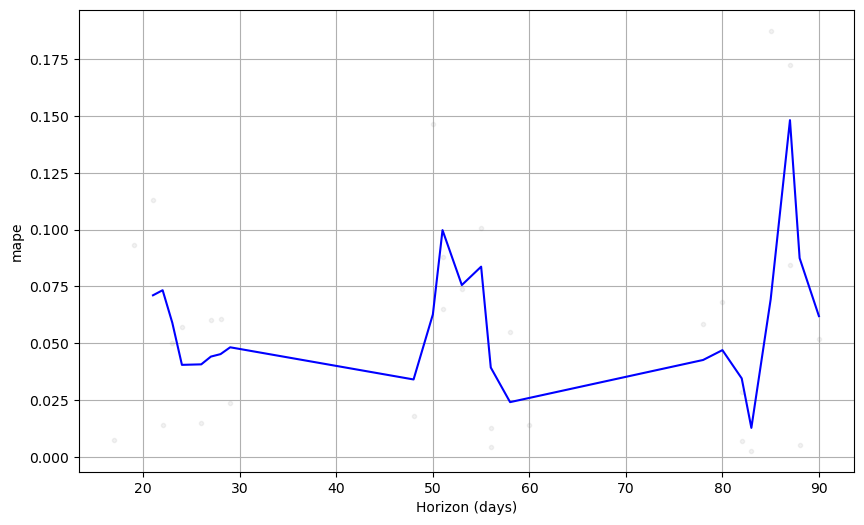

In [44]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [45]:
test_df

57    682.063073
58    755.796592
59    843.777256
Name: y, dtype: float64

In [46]:
pred

57    695.217282
58    665.808320
59    728.860303
Name: yhat, dtype: float64

# FORECASTING

In [47]:
model_forecast = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, seasonality_mode= 'additive',
                interval_width=0.95)

In [48]:
model_forecast.fit(sales_df)

15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:25 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [50]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [51]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [52]:
forecasted_f_df

ds        yhat  yhat_lower  yhat_upper
60 2024-01-01  757.399779  683.316154  828.257853
61 2024-02-01  838.734348  772.419421  911.739062
62 2024-03-01  844.268203  773.722818  913.361573

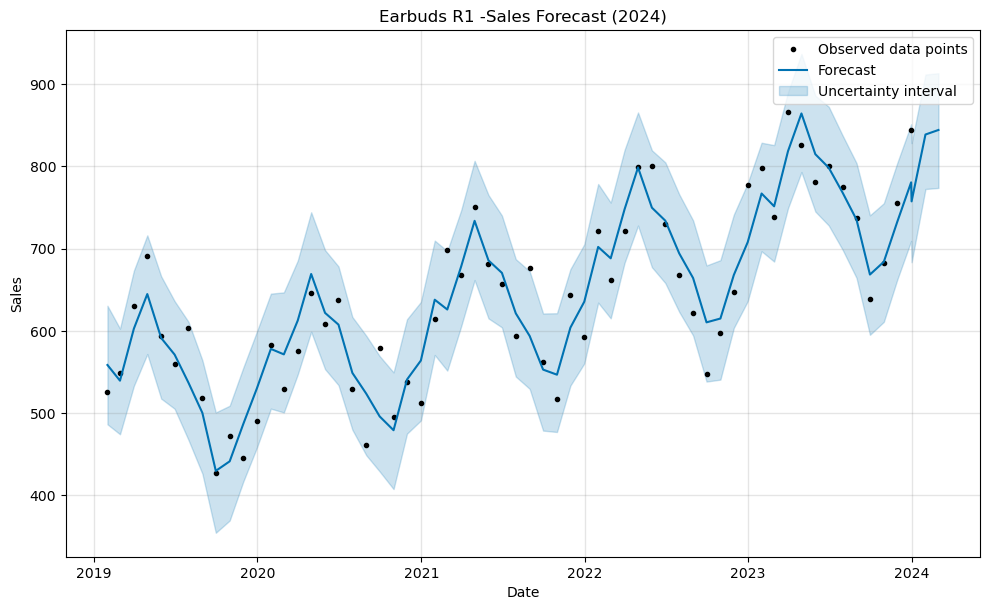

In [53]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Earbuds R1 -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [54]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [55]:
plot_components_plotly(model_forecast, forecast_f)